In [22]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import os
import galsim
import numpy as np
import fpfs
import matplotlib.pyplot as plt
import time

import batsim.pltutil as batplot
import batsim.stamp as batstamp
import batsim.transforms as batforms

##### hlr = 1.5
flux = 40
nn = 128
scale = 0.01

sersic_gal = galsim.Sersic(n=0.5, half_light_radius=hlr, flux=flux)

im_stamp = batstamp.Stamp(nn=nn, scale=scale, centering='galsim')

# IA = batforms.IaTransform(A=0.2, beta=0., phi=np.radians(0), hlr=hlr, scale=scale, center=[-0.5*scale, -0.5*scale])
# gamma1, gamma2 = IA.get_g1g2(0,0)

gamma1 = 0.2
gamma2 = 0.
kappa = 0.

mu = 1/((1-kappa)**2 - gamma1**2 - gamma2**2)
gals = sersic_gal.lens(g1=gamma1, g2=gamma2, mu=mu)
gal_im = gals.drawImage(nx=nn, ny=nn, scale=scale, method='sb')
Lens = batforms.LensTransform(gamma1=gamma1, gamma2=gamma2, kappa=kappa, center=[-0.5*scale, -0.5*scale])

im_stamp.transform_grids(Lens)
bats = im_stamp.sample_galaxy(sersic_gal)

plt.imshow(bats-gal_im.array)
plt.colorbar()

no_psf_residual = bats - gal_im.array

In [172]:
def interp_and_convolve(gal_arr, psf_obj, scale):
    
    # draw an image from the batsim flux array
    gal_im = galsim.Image(gal_arr, scale=scale)
    
    # intepolate the batsim image as a galsim object
    gal_obj = galsim.InterpolatedImage(gal_im, scale=scale,  normalization='sb')
    
    # convolve interpolated object with PSF 
    convolved = galsim.Convolve([gal_obj, psf_obj])
    
    return convolved

0.005904674530029297


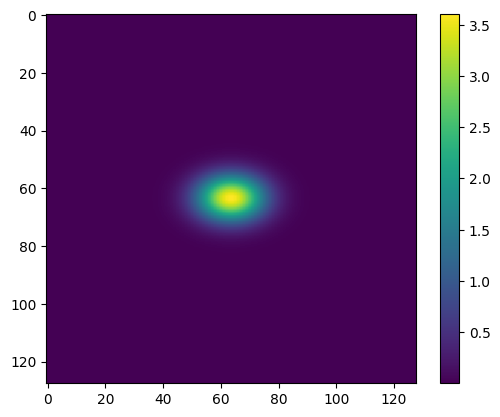

In [173]:
psf_obj = galsim.Moffat(beta=3.5, fwhm=0.6)

start = time.time()

conv_obj = interp_and_convolve(bats, psf_obj, scale)
conv_im = conv_obj.drawImage(nx=nn, ny=nn, scale=scale, method='sb')

end = time.time()
print(end-start)

plt.imshow(conv_im.array)
plt.colorbar()

0.0012340545654296875


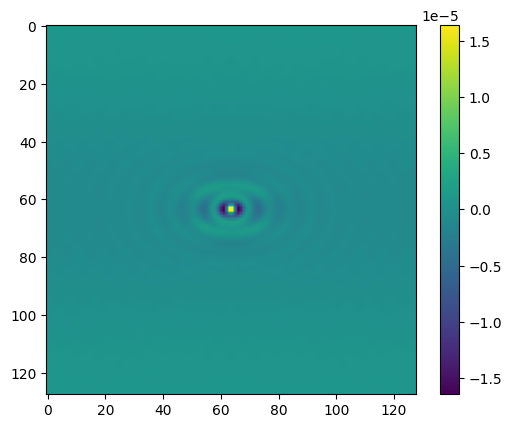

In [174]:
start = time.time()

galsim_conv = galsim.Convolve([gals, psf_obj]).drawImage(nx=nn, ny=nn, scale=scale, method='sb')
end = time.time()

print(end-start)

plt.imshow(conv_im.array - galsim_conv.array)
plt.colorbar()

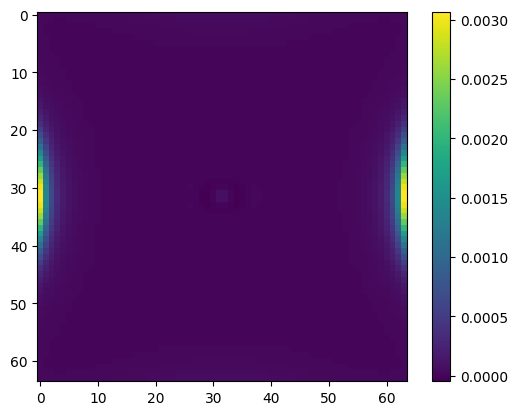

In [158]:
plt.imshow(conv_im.bin(2,2).array - galsim_conv.bin(2,2).array)
plt.colorbar()

In [141]:
hlr = 1.5
flux = 40
nn = 128
init_scale = 0.1

sersic_gal = galsim.Sersic(n=0.5, half_light_radius=hlr, flux=flux)
psf_obj = galsim.Moffat(beta=3.5, fwhm=0.6)
    
mals = np.linspace(1,10,40)

centre_residuals = []
interp_time = []
galsim_time = []
for m in mals:
    
    scale = init_scale * m

    im_stamp = batstamp.Stamp(nn=nn, scale=scale, centering='galsim')

    gamma1 = 0.2
    gamma2 = 0.
    kappa = 0.

    mu = 1/((1-kappa)**2 - gamma1**2 - gamma2**2)
    gals = sersic_gal.lens(g1=gamma1, g2=gamma2, mu=mu)
    gal_im = gals.drawImage(nx=nn, ny=nn, scale=scale, method='sb')
    
    Lens = batforms.LensTransform(gamma1=gamma1, gamma2=gamma2, kappa=kappa, center=[-0.5*scale, -0.5*scale])
    im_stamp.transform_grids(Lens)
    bats = im_stamp.sample_galaxy(sersic_gal)

    start = time.time()

    conv_obj = interp_and_convolve(bats, psf_obj, scale)
    interp_conv = conv_obj.drawImage(nx=nn, ny=nn, scale=scale, method='sb')

    end = time.time()
    
    interp_time.append(end-start)
    
    start = time.time()

    galsim_conv = galsim.Convolve([gals, psf_obj]).drawImage(nx=nn, ny=nn, scale=scale, method='sb')
    
    end = time.time()
    
    galsim_time.append(end-start)
    
    residuals = interp_conv.array - galsim_conv.array
    centre_residuals.append(residuals[32,32])

Text(0.5, 1.0, 'Residual at centre of image')

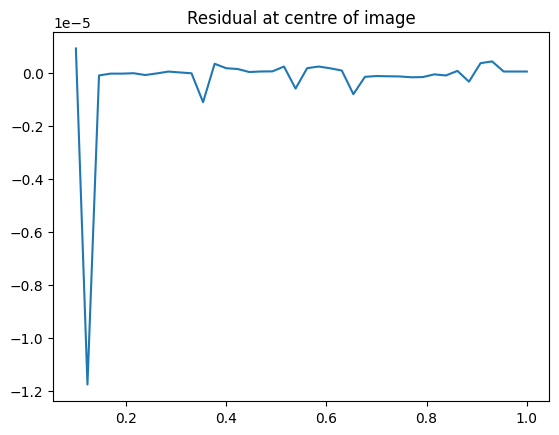

In [142]:
plt.plot(mals*init_scale, centre_residuals)
plt.title('Residual at centre of image')

Text(0.5, 1.0, 'InterpolatedImage convolution time / GSObject convolution time')

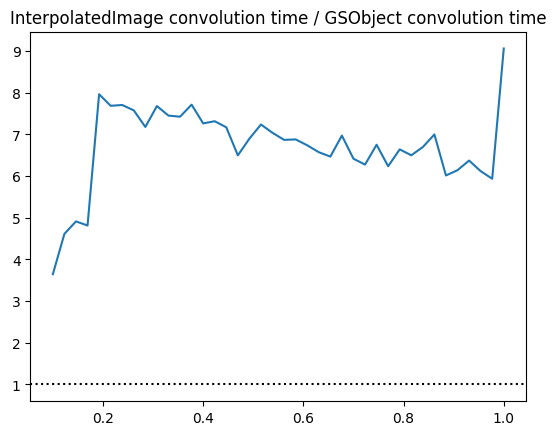

In [143]:
plt.plot(mals*init_scale, np.array(interp_time)/np.array(galsim_time))
plt.axhline(1, c='black', ls=':')
plt.title('InterpolatedImage convolution time / GSObject convolution time')

## Notes
- IA transform accuracy requires a ratio 